In [1]:
import torch
from torchvision import transforms, datasets
from torchsummary import summary
import torch.utils.data as data
import os
import glob
import cv2
from skimage import io
import numpy as np
import pathlib

In [2]:
from transformations import ComposeDouble, AlbuSeg2d, FunctionWrapperDouble, normalize_01, create_dense_target
from dataset import SegmentationDataSet
from trainer import Trainer
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import morphological as mph

In [3]:
data_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(degrees=(0,360)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.2, 0.2)),
        transforms.RandomAdjustSharpness(sharpness_factor=2),
        #transforms.Normalize(mean=[0.485, 0.456, 0.406],
        #                     std=[0.229, 0.224, 0.225])
    ])

# training transformations and augmentations
transforms_training = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(128, 128, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(128, 128),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(128, 128, 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(128, 128),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

In [4]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, transform=None):
        super(DataLoaderSegmentation, self).__init__()
        self.transform = transform
        self.inputs_dtype = torch.float32
        self.targets_dtype = torch.float32
        
        self.img_files = glob.glob(
            os.path.join(folder_path,'images','*.tiff')
        )
        self.mask_files = []
        for img_path in self.img_files:
             self.mask_files.append(
                 os.path.join(folder_path,'mask',os.path.basename(img_path)[:-4] + '.png')
             ) 

    def __getitem__(self, index):
        # Select sample
        img_path = self.img_files[index]
        mask_path = self.mask_files[index]
        
        # Load input and target
        x, y  = io.imread(img_path), io.imread(img_path, as_gray=True)
        
        # Preprocessing - data augmentation
        #x = np.transpose(x, (1, 2, 0))
        if self.transform:
            x, y = self.transform(x, y)
            
        # Typecasting
        x, y = torch.from_numpy(x).type(self.inputs_dtype), torch.from_numpy(y).type(self.targets_dtype)   
        
        return x, y

    def __len__(self):
        return len(self.img_files)

In [5]:
#folder_path=os.path.join(os.getcwd(), '..', '..', '..', 'treerings', 'data', 'train')
root = pathlib.Path.cwd() / '../../../treerings/data/train/'
print(root)

def get_filenames_of_path(path: pathlib.Path, ext: str = '*'):
    """Returns a list of files in a directory/path. Uses pathlib."""
    filenames = [file for file in sorted(path.glob(ext)) if file.is_file()]
    return filenames

inputs = get_filenames_of_path(root / 'images/', ext='*.tiff')
targets = get_filenames_of_path(root / 'mask/', ext='*.png')


#inputs = glob.glob(
#            os.path.join(folder_path,'images','*.tiff')
#        )
#targets = glob.glob(
#            os.path.join(folder_path,'mask','*.png')
#        )
# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

#tr_dataset = DataLoaderSegmentation(
#    folder_path=os.path.join(os.getcwd(), 'data', 'train'),
#    transform=None
#)

/volWork/Remi/treetrace/treerings/deeplearning/../../../treerings/data/train


In [6]:
batch_size = 32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# dataset training
dataset_train = SegmentationDataSet(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms_training)

# dataset validation
dataset_valid = SegmentationDataSet(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms_validation)

# dataloader training
dataloader_training = torch.utils.data.DataLoader(dataset=dataset_train,
                                 batch_size=batch_size,
                                 shuffle=True)

# dataloader validation
dataloader_validation = torch.utils.data.DataLoader(dataset=dataset_valid,
                                   batch_size=batch_size,
                                   shuffle=True)

In [7]:
import losses
import math
max_dist = math.sqrt(128**2 + 128**2)
n_pixels = 128 * 128
all_img_locations = torch.from_numpy(losses.cartesian([np.arange(128),
                                                       np.arange(128)]))
all_img_locations = all_img_locations.to(device)

cross = torch.tensor([[[0, 1, 0], [1, 1, 1], [0, 1, 0]]])
kernel = cross * 0.2
kernel = kernel[None]
    
def mcc_loss(output, target):
    mcc = 0.0
    for b in range(target.shape[0]):
        y_pred_pos = output[b]
        y_pred_neg = 1. - output[b]
        y_true_pos = target[b]
        y_true_neg = 1. - target[b]
    
        tp = torch.sum(y_pred_pos * y_true_pos)
        tn = torch.sum(y_pred_neg * y_true_neg)
        fp = torch.sum(y_pred_pos * y_true_neg)
        fn = torch.sum(y_pred_neg * y_true_pos)
        numerator = tn * tp - fn * fp
        denominator = torch.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
        mcc += 1. - numerator / (denominator + 1e-6)
    return mcc / target.shape[0]
    
def hd_loss(output, target):
    return _weightedHausdorffDistance(output, target, 
                                            max_dist=max_dist, 
                                            all_img_locations=all_img_locations,
                                            n_pixels=n_pixels,
                                            device=device)


def perform_erosion(pred, target, kernel, alpha = 2.0, k = 10):
    dilation = mph.Dilation2d(1, 1, 3, inference=True)
    dilation.kernel = torch.as_tensor(kernel, device=pred.device, dtype=pred.dtype)
    eps = 1e-6
    y_true = torch.as_tensor(target > 0, device=pred.device, dtype=pred.dtype)
    omega_true = [y_true] 
    omega_pred = [pred]
    for i in range(k):
        omega_true.append(dilation(omega_true[i])-0.2)
        omega_pred.append(dilation(omega_pred[i])-0.2)
        
    acc_true = (k+1) - torch.sum(torch.stack(omega_true), axis=0)
    acc_pred = (k+1) - torch.sum(torch.stack(omega_pred), axis=0)
    gap_pred2true = torch.mean(pred * acc_true, axis=[1,2,3])
    gap_true2pred = torch.mean(y_true * acc_pred, axis=[1,2,3])
    gap_pred = torch.mean(y_true, axis=[1,2,3])
    gap_true = torch.mean(pred, axis=[1,2,3])
    loss = torch.mean( 0.5 * (gap_pred2true + eps) / (gap_pred + eps) \
                        + 0.5 * (gap_true2pred + eps) / (gap_true +eps ))
    return loss

def new_loss(pred, target, alpha = 2.0, k = 10):
    cross = torch.tensor([[[0, 1, 0], [1, 1, 1], [0, 1, 0]]])
    kernel = cross * 0.2
    kernel = kernel[None]
    
    dilation = mph.Dilation2d(1, 1, 3, inference=True)
    dilation.kernel = torch.as_tensor(kernel, device=pred.device, dtype=pred.dtype)
    eps = 1e-6
    y_true = torch.as_tensor(target > 0, device=pred.device, dtype=pred.dtype)
    omega_true = [y_true] 
    for i in range(k):
        omega_true.append(dilation(omega_true[i])-0.2)
        
    acc_true = (k+1) - torch.sum(torch.stack(omega_true), axis=0)
    gap_pred2true = torch.mean(pred * acc_true, axis=[1,2,3])
    gap_pred = torch.mean(y_true, axis=[1,2,3])
    
    loss_d = torch.mean(gap_pred2true) #torch.mean( (gap_pred2true) / (gap_pred + eps) )
    loss_e = mcc_loss(pred, target)
    return loss_d + loss_e

def perform_loss(output, target):
    return perform_erosion(output, target, kernel)

def l1_loss(y_pred, y_true):
    n = torch.count_nonzero(y_true)
    beta = n / torch.numel(y_true)
    pos = y_true * y_pred
    neg = (1. - y_true) * y_pred
    l_pos = torch.nn.L1Loss()(pos, y_true)
    l_neg = torch.nn.L1Loss()(neg, y_true)
    return (1. - beta) * l_pos + beta * l_neg
    
def mce_l1_loss(out, target):
    loss_mce = mcc_loss(out, target)
    l1 = l1_loss(out, target)
    return loss_mce #+ 0.1*l1

In [8]:
import network

class MyModel(torch.nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        #self.backbone = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
        #                               in_channels=3, out_channels=1, init_features=32, pretrained=True)
    
        #self.ero1 = mph.Erosion2d(1, 1, 7)
        #self.ero2 = mph.Erosion2d(1, 1, 5)
        #self.ero3 = mph.Erosion2d(1, 1, 3)
        MODEL_NAME = "deeplabv3plus_resnet101"
        PATH_TO_PTH = "best_deeplabv3plus_resnet101_voc_os16.pth"
        self.backbone = network.modeling.__dict__[MODEL_NAME](num_classes=1, output_stride=1)
        self.backbone.load_state_dict( torch.load( PATH_TO_PTH )['model_state']  )
        self.out = torch.nn.Hardsigmoid()
        
    def forward(self, x):
        x = self.backbone(x)
        return self.out(x)
    

model = MyModel()
model.load_state_dict()
model = model.to(device)
summary(model)
#summary(model, (1, 128, 128))
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Layer (type:depth-idx)                   Param #
├─DeepLabV3: 1-1                         --
|    └─IntermediateLayerGetter: 2-1      --
|    |    └─Conv2d: 3-1                  9,408
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─MaxPool2d: 3-4               --
|    |    └─Sequential: 3-5              215,808
|    |    └─Sequential: 3-6              1,219,584
|    |    └─Sequential: 3-7              26,090,496
|    |    └─Sequential: 3-8              14,964,736
|    └─DeepLabHeadV3Plus: 2-2            --
|    |    └─Sequential: 3-9              12,384
|    |    └─ASPP: 3-10                   15,535,104
|    |    └─Sequential: 3-11             701,185
├─Hardsigmoid: 1-2                       --
Total params: 58,748,833
Trainable params: 58,748,833
Non-trainable params: 0


In [9]:
# trainer
_trainer = Trainer(model=model,
                  device=device,
                  criterion=new_loss,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=10,
                  epoch=0,
                  notebook=True)

In [13]:
training_losses, validation_losses, lr_rates = _trainer.run_trainer()

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

Training:   0%|          | 0/93 [00:00<?, ?it/s]

Validation:   0%|          | 0/24 [00:00<?, ?it/s]

tensor(0.0316, device='cuda:0')
tensor(0.0316, device='cuda:0')


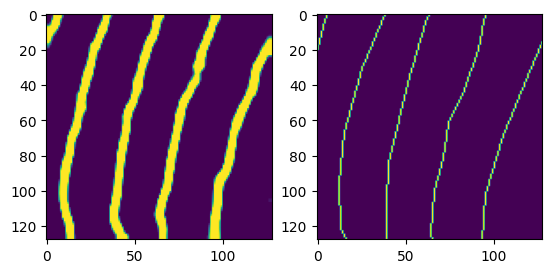

In [15]:
import matplotlib.pyplot as plt
from skimage import filters
x, y = dataset_valid[100]
x = x.to(device)
y1 = model(x.unsqueeze(0))
img = np.transpose(x.cpu().detach().numpy(), (1,2,0))
mask_1 = y1.cpu().detach().numpy()[0,0]
mask_2 = y.cpu().detach().numpy()[0]
fig, axs = plt.subplots(ncols=2)
#delta = mask > filters.threshold_otsu(mask)
#img[delta==1, 0] = 1
axs[0].imshow(mask_1)
axs[1].imshow(mask_2)
print(l1_loss(torch.zeros_like(y).to(device), y.to(device)))
print(torch.nn.L1Loss()(torch.zeros_like(y).to(device), y.to(device)))

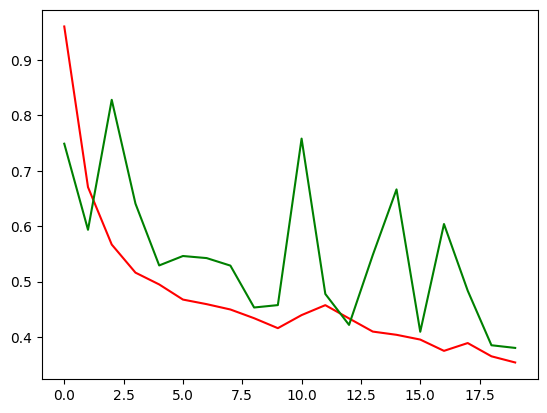

In [17]:
plt.plot(training_losses, 'red')
plt.plot(validation_losses, 'green')